## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=f07964cb-3010-4914-8349-01b975983039
To: /Users/Matthieu/Documents/GitHub/NX-414/Week 6/IT_data.h5
100%|██████████| 384M/384M [00:21<00:00, 17.9MB/s] 


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


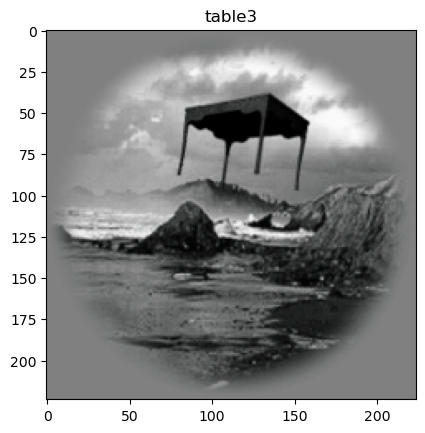

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

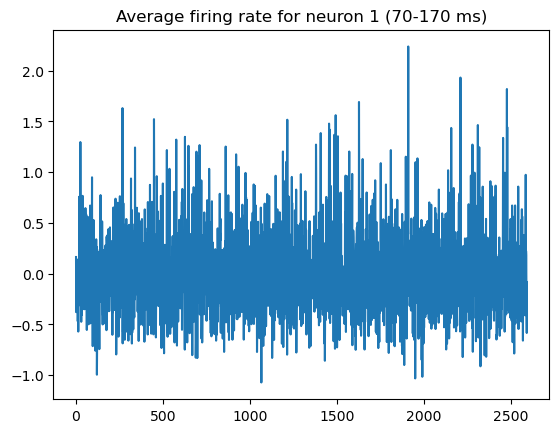

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [7]:
from utils import list_to_classes, classes_to_int

def preprocess_data(stimulus_train, stimulus_val, objects_train, objects_val):
    """Function to preprocess data by flattening, normalizing, and augmenting with class labels.
    
    Args:
    stimulus_train: Training stimulus data (images).
    stimulus_val: Validation stimulus data (images).
    objects_train: Training object labels.
    objects_val: Validation object labels.
    
    Returns:
    X_train_augmented: Preprocessed and augmented training data.
    X_val_augmented: Preprocessed and augmented validation data.
    """
    # Transform object classes
    objects_train_classes = list_to_classes(objects_train)
    objects_val_classes = list_to_classes(objects_val)

    objects_train_int = classes_to_int(objects_train_classes)
    objects_val_int = classes_to_int(objects_val_classes)

    # Preprocess data (flatten and normalize)
    X_train = stimulus_train.reshape(stimulus_train.shape[0], -1) / 255.0
    X_val = stimulus_val.reshape(stimulus_val.shape[0], -1) / 255.0

    # Append the transformed class labels as additional features
    X_train_augmented = np.hstack((X_train, np.array(objects_train_int).reshape(-1, 1)))
    X_val_augmented = np.hstack((X_val, np.array(objects_val_int).reshape(-1, 1)))

    return X_train_augmented, X_val_augmented

In [8]:
from sklearn.metrics import explained_variance_score
from utils import compute_corr

def train_and_evaluate(model, model_name, X_train, X_val, spikes_train, spikes_val):
    """Function to train and evaluate a regression model.
    
    Args: 
    model: regression model
    model_name: name of the model
    X_train: training data (features)
    X_val: validation data (features)
    spikes_train: training data (target neural activity)
    spikes_val: validation data (target neural activity)
    """
    print(f"Training {model_name}:")
    model.fit(X_train, spikes_train)

    # Make predictions using validation set
    y_pred = model.predict(X_val)

    # Compute explained variance
    ev_per_neuron = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
    overall_ev = np.mean(ev_per_neuron)
    print(f'Overall explained variance:', overall_ev)

    # Compute correlation between predicted values and real values
    corr_per_neuron = compute_corr(spikes_val, y_pred, divide=True)
    overall_corr = compute_corr(spikes_val, y_pred)
    print(f'Overall correlation:', overall_corr)

    # Plot histograms for explained variance and correlation
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram of explained variance per neuron
    axs[0].hist(ev_per_neuron, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axs[0].set_title(f'{model_name} - Explained variance per neuron')
    axs[0].set_xlabel('Explained variance')
    axs[0].set_ylabel('Frequency')

    # Histogram of correlation per neuron
    axs[1].hist(corr_per_neuron, bins=20, color='green', alpha=0.7, edgecolor='black')
    axs[1].set_title(f'{model_name} - Correlation per neuron')
    axs[1].set_xlabel('Correlation coefficient')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

Training Ridge Regression:
Overall explained variance: 0.09528300198675552
Overall correlation: 0.2932040581296197


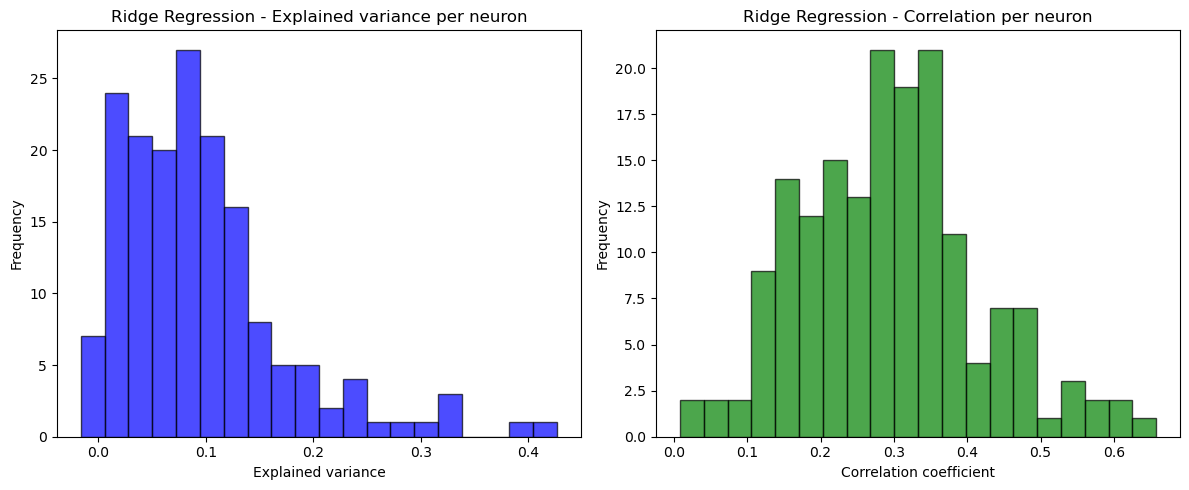

In [9]:
from sklearn.linear_model import Ridge, LinearRegression

# Preprocess data
X_train_augmented, X_val_augmented = preprocess_data(stimulus_train, stimulus_val, objects_train, objects_val)

# Train and evaluate Ridge Regression
ridge = Ridge(alpha=10, fit_intercept=True)
train_and_evaluate(ridge, "Ridge Regression", X_train_augmented, X_val_augmented, spikes_train, spikes_val)

# Train and evaluate Least-Square Regression
# least_squares = LinearRegression(fit_intercept=True)
# train_and_evaluate(least_squares, "Least-Square Regression", X_train_augmented, X_val_augmented, spikes_train, spikes_val)

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [10]:
from sklearn.decomposition import PCA

# Function to preprocess data with PCA
def preprocess_data_pca(stimulus_train, stimulus_val, objects_train, objects_val, n_components=1000):
    """Function to preprocess data by applying PCA, normalizing, and augmenting with class labels.
    
    Args:
    stimulus_train: Training stimulus data (images).
    stimulus_val: Validation stimulus data (images).
    objects_train: Training object labels.
    objects_val: Validation object labels.
    n_components: Number of principal components to retain.
    
    Returns:
    X_train_augmented: Preprocessed and augmented training data.
    X_val_augmented: Preprocessed and augmented validation data.
    """
    # Transform object classes
    objects_train_classes = list_to_classes(objects_train)
    objects_val_classes = list_to_classes(objects_val)

    objects_train_int = classes_to_int(objects_train_classes)
    objects_val_int = classes_to_int(objects_val_classes)

    # Preprocess data (flatten and normalize)
    X_train = stimulus_train.reshape(stimulus_train.shape[0], -1) / 255.0
    X_val = stimulus_val.reshape(stimulus_val.shape[0], -1) / 255.0

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    print(f"PCA complete. Explained variance ratio (first {n_components} PCs): {np.sum(pca.explained_variance_ratio_):.2f}\n")

    # Append the transformed class labels as additional features
    X_train_augmented = np.hstack((X_train_pca, np.array(objects_train_int).reshape(-1, 1)))
    X_val_augmented = np.hstack((X_val_pca, np.array(objects_val_int).reshape(-1, 1)))

    return X_train_augmented, X_val_augmented

PCA complete. Explained variance ratio (first 1000 PCs): 0.98

Training Ridge regression with PCA:
Overall explained variance: 0.09480306609177817
Overall correlation: 0.29218235796519004


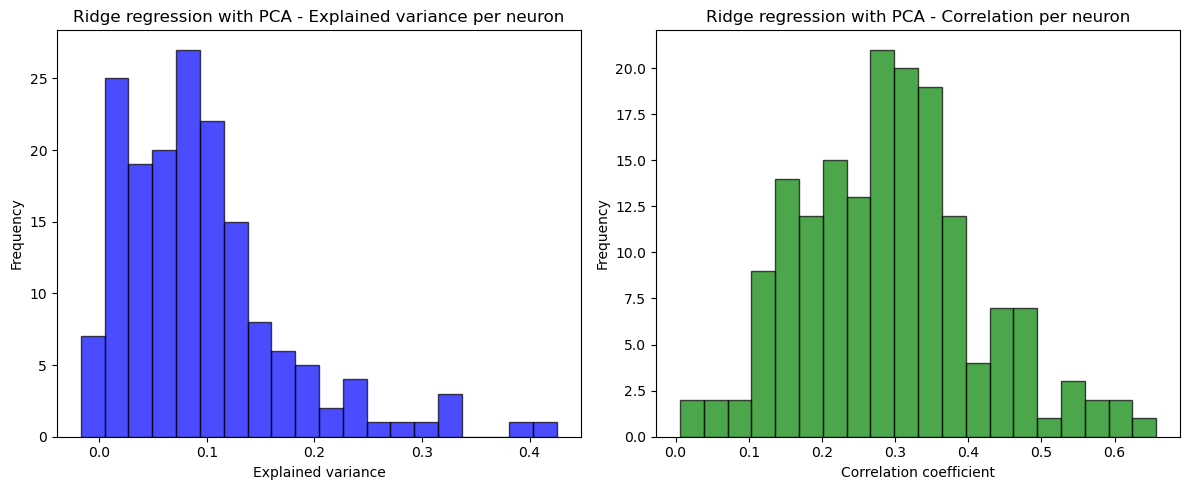

In [11]:
# Preprocess data with PCA
X_train_augmented_pca, X_val_augmented_pca = preprocess_data_pca(stimulus_train, stimulus_val, objects_train, objects_val, n_components=1000)

# Train and evaluate Ridge Regression with PCA
ridge = Ridge(alpha=10, fit_intercept=True)
train_and_evaluate(ridge, "Ridge regression with PCA", X_train_augmented_pca, X_val_augmented_pca, spikes_train, spikes_val)

# Train and evaluate Least-Square Regression with PCA
# least_squares = LinearRegression(fit_intercept=True)
# train_and_evaluate(least_squares, "Least-square regression with PCA", X_train_augmented_pca, X_val_augmented_pca, spikes_train, spikes_val)

Based on the results, we see that the first 1000 PCs explain almost the entirety of the model. Indeed, the the overall explained variance is about 0.09478, compared to 0.09528 originally, and the overall correlation is 0.2922, compared to 0.2932 originally.

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [12]:
from sklearn.model_selection import StratifiedKFold

def cross_validate_ridge(X, y, objects, alphas, n_splits=5):
    """Perform cross-validation to find the best alpha for Ridge Regression.
    
    Args:
    X: Feature matrix.
    y: Target matrix (neural activity).
    objects: Class labels for stratification.
    alphas: List of alpha values to test.
    n_splits: Number of cross-validation splits.
    
    Returns:
    best_alpha: The alpha value that gives the best performance.
    """
    best_alpha = None
    best_score = -np.inf

    for alpha in alphas:
        ridge = Ridge(alpha=alpha, fit_intercept=True)
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        fold_scores = []
        for train_idx, val_idx in skf.split(X, objects):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Train Ridge Regression
            ridge.fit(X_train, y_train)
            
            # Predict and evaluate explained variance
            y_pred = ridge.predict(X_val)
            ev_per_neuron = explained_variance_score(y_val, y_pred, multioutput='raw_values')
            fold_scores.append(np.mean(ev_per_neuron))
        
        # Average score across folds
        mean_score = np.mean(fold_scores)
        print(f"alpha={alpha}, mean explained variance: {mean_score:.4f}")
        
        # Update best alpha if this one is better
        if mean_score > best_score:
            best_score = mean_score
            best_alpha = alpha

    print(f"\nBest alpha: {best_alpha} with mean explained variance: {best_score:.4f} \n")
    return best_alpha

PCA complete. Explained variance ratio (first 1000 PCs): 0.98

alpha=1, mean explained variance: 0.0643
alpha=2, mean explained variance: 0.0806
alpha=5, mean explained variance: 0.0873
alpha=10, mean explained variance: 0.0861
alpha=15, mean explained variance: 0.0836
alpha=30, mean explained variance: 0.0768
alpha=100, mean explained variance: 0.0595
alpha=1000, mean explained variance: 0.0274

Best alpha: 5 with mean explained variance: 0.0873 

Training Ridge regression with PCA (alpha=5):
Overall explained variance: 0.09668121987785641
Overall correlation: 0.29288793956489867


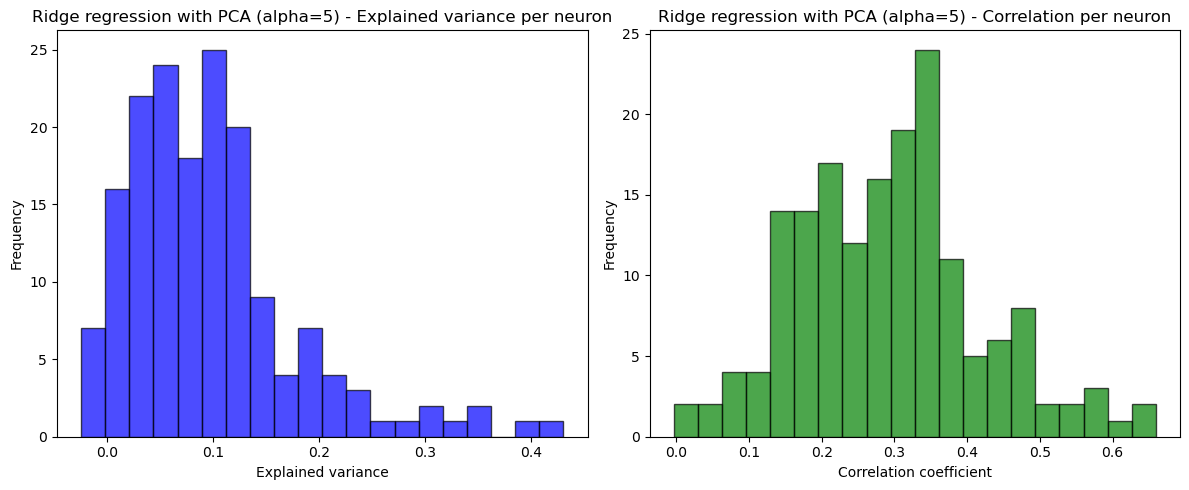

In [13]:
# Preprocess data with PCA
X_train_augmented_pca, X_val_augmented_pca = preprocess_data_pca(
    stimulus_train, stimulus_val, objects_train, objects_val, n_components=1000
)

# Combine train and validation data for cross-validation
X_combined = np.vstack((X_train_augmented_pca, X_val_augmented_pca))
y_combined = np.vstack((spikes_train, spikes_val))
objects_combined = np.hstack((objects_train, objects_val))

# Perform cross-validation to find the best alpha
alphas = [1, 2, 5, 10, 15, 30, 100, 1000]
best_alpha = cross_validate_ridge(X_combined, y_combined, objects_combined, alphas)

# Train and evaluate Ridge Regression with the best alpha
ridge = Ridge(alpha=best_alpha, fit_intercept=True)
train_and_evaluate(ridge, f"Ridge regression with PCA (alpha={best_alpha})", X_train_augmented_pca, X_val_augmented_pca, spikes_train, spikes_val)

We can improve the prediction with cross-fold validation to find the best parameter for ridge regression. With the best alpha value of 5, we go from 0.09478 to 0.09689 in overall explained variance, and from 0.2922 to 0.2933 in overall correlation (original alpha value of 10). But despite all these efforts, we do not observe a significant amelioration in explained variance, which suggests that the model is not able to generalize well enough to new data. 

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?